<a href="https://colab.research.google.com/github/RewinaB/Deep-Learning-Projects/blob/main/Workforce_forecasting_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workforce Planning & Forecasting
This notebook demonstrates four modeling approaches:
1. Time Series Forecasting
2. Regression Modeling
3. Markov Model for Internal Movement
4. Skill Gap Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


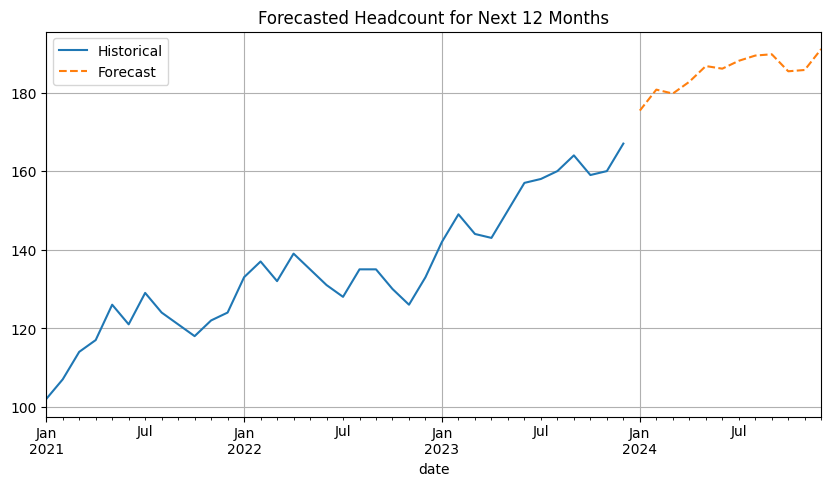

In [2]:
df = pd.read_csv('/content/headcount_by_month.csv', parse_dates=['date'], index_col='date')
model = ExponentialSmoothing(df['headcount'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()
forecast = fit.forecast(12)

plt.figure(figsize=(10,5))
df['headcount'].plot(label='Historical')
forecast.plot(label='Forecast', linestyle='--')
plt.title('Forecasted Headcount for Next 12 Months')
plt.legend()
plt.grid()
plt.show()


/tmp/ipython-input-3-2894692471.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start='2020-01-01', periods=48, freq='M')
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_k639h0/8v26itix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_k639h0/5dcqd2py.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62777', 'data', 'file=/tmp/tmpj_k639h0/8v26itix.json', 'init=/tmp/tmpj_k639h0/5dcqd2py.json', 'output', 'file=/tmp/tmpj_k639h0/prophet_model2c54hzzl/prophet_model-20250626223403.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:34:03 - cmdstanpy - INFO - 

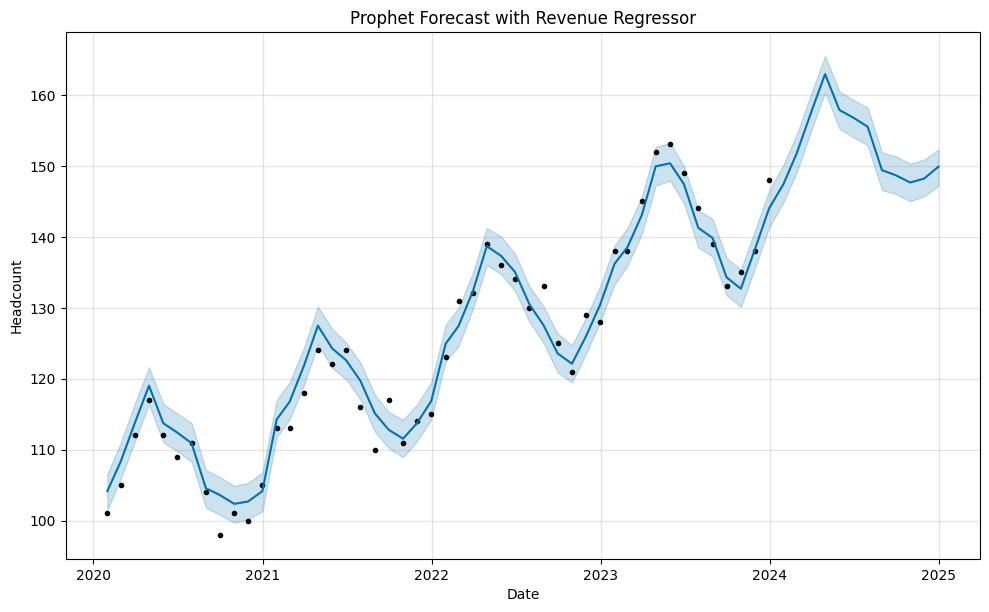

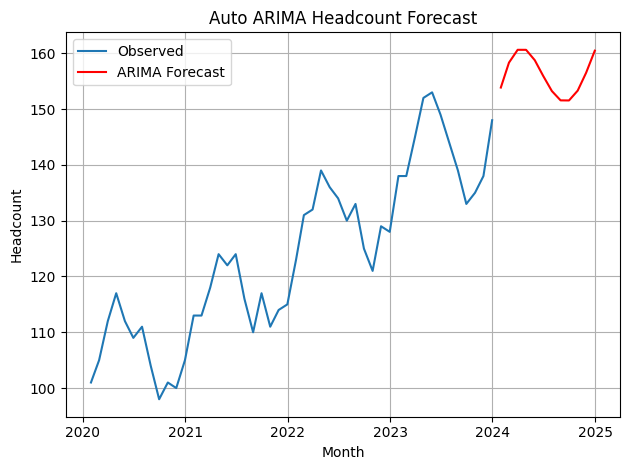

In [3]:
# Install required packages
!pip install numpy==1.25.2
!pip install pmdarima prophet --quiet --upgrade

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Simulate a simple time series dataset with seasonality
np.random.seed(42)
months = pd.date_range(start='2020-01-01', periods=48, freq='M')
headcount = (100 + np.linspace(0, 50, 48) + 10 * np.sin(np.arange(48) * 2 * np.pi / 12) + np.random.normal(0, 3, 48)).astype(int)
revenue = 200 + np.linspace(0, 100, 48) + np.random.normal(0, 5, 48)
df = pd.DataFrame({'month': months, 'headcount': headcount, 'revenue': revenue})

# Prepare data for Prophet
df_prophet = df[['month', 'headcount']].rename(columns={'month': 'ds', 'headcount': 'y'})

# Add external regressor
df_prophet['revenue'] = df['revenue']

# Fit Prophet with external regressor
prophet_model = Prophet()
prophet_model.add_regressor('revenue')
prophet_model.fit(df_prophet)

# Create future dataframe
future = prophet_model.make_future_dataframe(periods=12, freq='M')
future['revenue'] = 250 + np.linspace(0, 20, 60)  # hypothetical future revenue trend
forecast = prophet_model.predict(future)

# Plot forecast
fig1 = prophet_model.plot(forecast)
plt.title("Prophet Forecast with Revenue Regressor")
plt.xlabel("Date")
plt.ylabel("Headcount")

# Now try auto_arima for model comparison
auto_model = auto_arima(df['headcount'], seasonal=True, m=12, trace=False)
forecast_arima = auto_model.predict(n_periods=12)
forecast_index = pd.date_range(start=months[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Plot ARIMA forecast
plt.figure()
plt.plot(df['month'], df['headcount'], label='Observed')
plt.plot(forecast_index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title("Auto ARIMA Headcount Forecast")
plt.xlabel("Month")
plt.ylabel("Headcount")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**OLS Regression**

In [4]:
df = pd.read_csv('/content/talent_demand_regression.csv')
X = df[['revenue', 'product_launches']]
y = df['hires_needed']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           hires_needed   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     367.7
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           2.78e-23
Time:                        22:34:12   Log-Likelihood:                -70.734
No. Observations:                  36   AIC:                             147.5
Df Residuals:                      33   BIC:                             152.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.0645      2.855  

In [5]:
transition_matrix = pd.read_csv('markov_transition_matrix.csv', index_col=0)
print("/content/Markov Transition Matrix:")
display(transition_matrix)

# Simulate one-step transition from 'Junior'
state = 'Junior'
next_state_probs = transition_matrix.loc[state]
print(f"Probabilities of transitioning from {state}:")
print(next_state_probs)


/content/Markov Transition Matrix:


,Intern,Junior,Mid,Senior,Manager,Exit
Intern,0.1,0.6,0.2,0.0,0.0,0.1
Junior,0.0,0.2,0.6,0.1,0.0,0.1
Mid,0.0,0.0,0.3,0.5,0.1,0.1
Senior,0.0,0.0,0.0,0.4,0.4,0.2
Manager,0.0,0.0,0.0,0.0,0.8,0.2
Exit,0.0,0.0,0.0,0.0,0.0,1.0


Probabilities of transitioning from Junior:
Intern     0.0
Junior     0.2
Mid        0.6
Senior     0.1
Manager    0.0
Exit       0.1
Name: Junior, dtype: float64


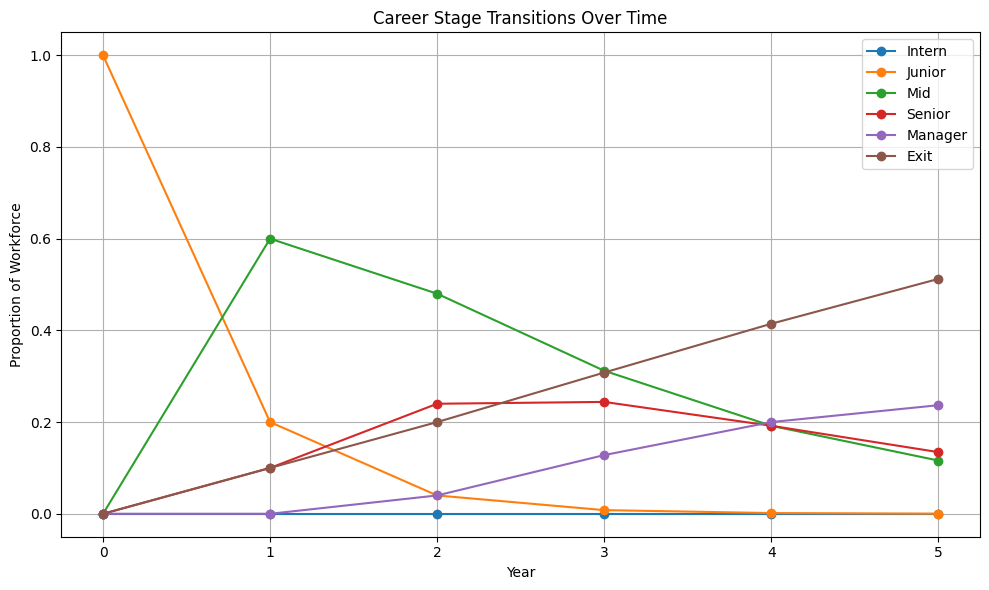

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define career stages
states = ['Intern', 'Junior', 'Mid', 'Senior', 'Manager', 'Exit']

# Define the transition matrix (columns are "to", rows are "from")
transition_matrix = np.array([
    [0.6, 0.3, 0.1, 0.0, 0.0, 0.0],   # From Intern
    [0.0, 0.2, 0.6, 0.1, 0.0, 0.1],   # From Junior
    [0.0, 0.0, 0.6, 0.3, 0.0, 0.1],   # From Mid
    [0.0, 0.0, 0.0, 0.4, 0.4, 0.2],   # From Senior
    [0.0, 0.0, 0.0, 0.0, 0.8, 0.2],   # From Manager
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    # From Exit (absorbing state)
])

# Starting distribution: 100 employees all at Junior level
initial_distribution = np.array([0, 1, 0, 0, 0, 0])

# Simulate transitions for 5 years
distributions = [initial_distribution]
for _ in range(5):
    next_distribution = distributions[-1] @ transition_matrix
    distributions.append(next_distribution)

# Convert results into a DataFrame for visualization
df_forecast = pd.DataFrame(distributions, columns=states)
df_forecast['Year'] = range(6)
df_forecast = df_forecast.set_index('Year')


# Plot the results
df_forecast.plot(marker='o', figsize=(10, 6))
plt.title("Career Stage Transitions Over Time")
plt.ylabel("Proportion of Workforce")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


Year 1:

60% moved to Mid

20% remained Junior

10% moved to Senior

10% exited

Year 2 onward:

Gradual flow from Mid → Senior → Manager

Steady increase in Exit, indicating attrition over time

Decrease in Junior, indicating successful upward mobility

Average Number of Missing Skills by Role:


,role,num_missing
0,Analyst,1.857143
1,Data Scientist,1.750000
2,Manager,2.310345


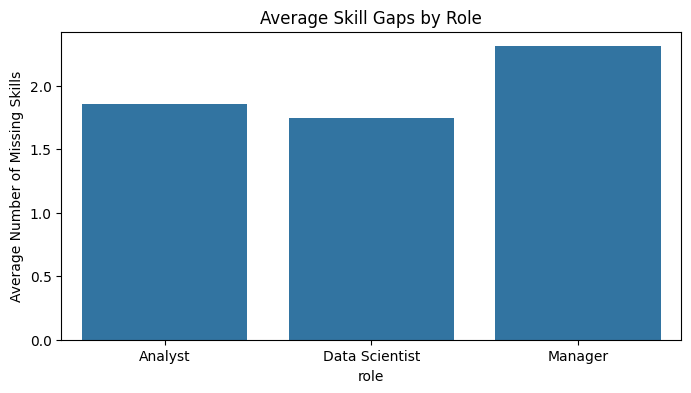

In [6]:
df = pd.read_csv('/content/skill_gap_data.csv')
df['current_skills'] = df['current_skills'].apply(eval)
df['required_skills'] = df['required_skills'].apply(eval)

# Count missing skills
df['missing_skills'] = df.apply(lambda x: list(set(x['required_skills']) - set(x['current_skills'])), axis=1)
df['num_missing'] = df['missing_skills'].apply(len)

# Summary
gap_summary = df.groupby('role')['num_missing'].mean().reset_index()
print("Average Number of Missing Skills by Role:")
display(gap_summary)

# Barplot
plt.figure(figsize=(8,4))
sns.barplot(data=gap_summary, x='role', y='num_missing')
plt.title("Average Skill Gaps by Role")
plt.ylabel("Average Number of Missing Skills")
plt.show()


The Manager role has the highest average skill gap, suggesting future leadership pipelines might be weak or underprepared unless upskilling occurs.